In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import shapefile
import pyproj

#! /usr/bin/env python3

# data libraries
import sys
import os
import datetime as dt  # Python standard library datetime  module
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from netCDF4 import Dataset,num2date  # http://code.google.com/p/netcdf4-python/
import pandas as pd
import geopandas as gpd
from pyproj import Proj, transform
from matplotlib.path import Path

# plotting libraries
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.style as style
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point 
import cartopy.mpl.ticker as cticker
import glob
import array

In [23]:
def bias_analysis_shelf(shelf_name,type_of_analysis):

    %matplotlib inline
    if type_of_analysis == 'yearly':
        shelf = yearly_shelves[shelf_name]
        shelf_reanalysis = yearly_reanalysis[shelf_name]
        
        y1 = shelf_reanalysis['year'][0][0]
        y2 = shelf_reanalysis['year'][0][-1]

        data_for_indicies_of_array_to_fill = yearly_shelves[shelf_name]['year'][0]

        index1_fill = np.where(data_for_indicies_of_array_to_fill == y1)[0][0]
        index2_fill = np.where(data_for_indicies_of_array_to_fill == y2)[0][-1]
        
        shelf_cropped = np.zeros((len(shelf['year']),len(shelf['year'][0][index1_fill:index2_fill])))
        shelf_cropped_temp = np.zeros((len(shelf['year']),len(shelf['year'][0][index1_fill:index2_fill]),len(shelf['cropped lon'][0])))
        shelf_cropped_temp_spatial_avg = np.zeros((len(shelf['year'])+1,len(shelf['year'][0][index1_fill:index2_fill])))
        
        for i in range(len(shelf['year'])):
            data_for_indicies = yearly_shelves[shelf_name]['year'][i]

            index1 = np.where(data_for_indicies == y1)[0][0]
            index2 = np.where(data_for_indicies == y2)[0][-1]
            
            shelf_cropped[i] = shelf['year'][i][index1:index2]
            shelf_cropped_temp[i] = shelf['cropped temp'][i][index1:index2]
            shelf_cropped_temp_spatial_avg[i] = shelf['temp spatial average'][i][index1:index2]
        
        print(np.shape(shelf_cropped_temp_spatial_avg))
        
        model_names = list(shelf['Model'])
        
        model_mean = np.mean(shelf_cropped_temp_spatial_avg,axis=0)
        
        
        model_temps_at_year = np.zeros((len(shelf_cropped_temp_spatial_avg)))
        std_model_temps_at_year = np.zeros((len(shelf_cropped_temp_spatial_avg[0])))
        margin_error = np.zeros((len(shelf_cropped_temp_spatial_avg[0])))
    
        z_star = 2.57 #95% confidence interval
        for k in range(len(shelf_cropped_temp_spatial_avg[0])):
            for i in range(len(shelf_cropped_temp_spatial_avg)):
                model_temps_at_year[i] = shelf_cropped_temp_spatial_avg[i][k]
            std_model_temps_at_year[k] = np.std(model_temps_at_year)
            margin_error[k] = z_star * (std_model_temps_at_year[k]/np.sqrt(len(shelf_cropped_temp)))
        
        avg_std_model_temps = np.mean(std_model_temps_at_year)
        
        model_names.append('Model Mean')
        
        
        shelf_cropped_temp_spatial_avg[-1]= model_mean
        
        
        variation = shelf_cropped_temp_spatial_avg - shelf_reanalysis['temp spatial average'][0][0:-1]
        mean_bias = np.mean(variation,axis=1)
        

        #Making data frame for bias analysis
        df = pd.DataFrame(list(zip(model_names,mean_bias)),columns=['Model Names','Mean Bias'])

        df_sortted = df.sort_values("Mean Bias",ascending=False)

        x = df_sortted['Model Names']
        y = df_sortted['Mean Bias']

        cmap = plt.cm.seismic
        norm = cm.colors.TwoSlopeNorm(vcenter=0,vmin=np.min(y),vmax=np.max(y))

        fig = plt.figure()
        fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(22, 10), tight_layout=False)
        #plt.tick_params(labelsize=20)
        plt.tight_layout()
        
        for i in range(len(shelf_cropped_temp)):
            ax1.plot(shelf_cropped[i],shelf_cropped_temp_spatial_avg[i],linewidth=1,label = '_nolegend_', color= 'lightgray')
        
        ax1.text(0.05, 0.9,'Shelf: {}'.format(shelf_name),fontsize = 20, ha='left', va='center', transform=ax1.transAxes,bbox=dict(boxstyle="square",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
        ax1.plot(shelf_cropped[0],model_mean,label = 'Multi-Model Mean', color= '#D55E00')
        ax1.plot(shelf_reanalysis['year'][0],shelf_reanalysis['temp spatial average'][0],label = 'ERA5', color= '#0072B2')
        ax1.set_xlabel("Time(Years)", fontsize = 20)
        ax1.set_ylabel(r"Annual Surface Temperature ($\degree$ C)", fontsize = 22)
        ax1.tick_params(labelsize=16)
        ax1.legend(loc = 'lower right',fontsize=20)
        
        bars = ax2.barh(x,y,align='center',color=cmap(norm(y.values)))
        ax2.bar_label(bars,fmt = '%1.1f',padding=2,label_type='edge',fontsize=16)
        ax2.set_xlim(left=min(y)-1.5)
        ax2.set_xlim(right=max(y)+1.5)
        ax2.set_xlabel(r"Mean Annual Temperature Bias($\degree$ C)", fontsize = 22)
        ax2.yaxis.set_label_position("right")
        ax2.tick_params(labelsize=20)
        ax2.yaxis.tick_right()
    
        my_path = '/raid01/mafields/tas/MODELS_filtered/ssp585/figures/bias/shelves_yearly/' # Figures out the absolute path for you in case your working directory moves around.
        my_file = shelf_name + '_yearly_bias.png'
   
        plt.savefig(os.path.join(my_path, my_file), bbox_inches='tight')
    
    
    else: 
        shelf = seasonal_shelves[shelf_name]
        shelf_reanalysis = seasonal_reanalysis[shelf_name]
        
        y1 = shelf_reanalysis['year'][0][0]
        y2 = shelf_reanalysis['year'][0][-1]

        data_for_indicies_of_array_to_fill = yearly_shelves[shelf_name]['year'][0]

        index1_fill = np.where(data_for_indicies_of_array_to_fill == y1)[0][0]
        index2_fill = np.where(data_for_indicies_of_array_to_fill == y2)[0][-1]+1
        
        shelf_cropped = np.zeros((len(shelf['year']),len(shelf['year'][0][index1_fill:index2_fill])))
        shelf_cropped_temp = np.zeros((len(shelf['year']),len(shelf['year'][0][index1_fill:index2_fill]),len(shelf['original latitude'][0]),len(shelf['original longitude'][0])))
        shelf_cropped_temp_spatial_avg = np.zeros((len(shelf['year'])+1,len(shelf['year'][0][index1_fill:index2_fill])))
        
        print(np.shape(shelf_cropped_temp))

        for i in range(len(shelf['year'])):
            data_for_indicies = yearly_shelves[shelf_name]['year'][i]

            index1 = np.where(data_for_indicies == y1)[0][0]
            index2 = np.where(data_for_indicies == y2)[0][-1]+1
            
            shelf_cropped[i] = shelf['year'][i][index1:index2]
            shelf_cropped_temp[i] = shelf['temp'][i][index1:index2]
            shelf_cropped_temp_spatial_avg[i] = shelf['temp spatial average'][i][index1:index2]
            
        model_names = list(shelf['Model'])
        
        model_mean = np.mean(shelf_cropped_temp_spatial_avg,axis=0)
        
        model_temps_at_year = np.zeros((len(shelf_cropped_temp_spatial_avg)))
        std_model_temps_at_year = np.zeros((len(shelf_cropped_temp_spatial_avg[0])))
        margin_error = np.zeros((len(shelf_cropped_temp_spatial_avg[0])))
    
        z_star = 2.57 #95% confidence interval
        for k in range(len(shelf_cropped_temp_spatial_avg[0])):
            for i in range(len(shelf_cropped_temp_spatial_avg)):
                model_temps_at_year[i] = shelf_cropped_temp_spatial_avg[i][k]
            std_model_temps_at_year[k] = np.std(model_temps_at_year)
            margin_error[k] = z_star * (std_model_temps_at_year[k]/np.sqrt(len(shelf_cropped_temp)))
            
        avg_std_model_temps = np.mean(std_model_temps_at_year)
        
        model_names.append('Model Mean')
        
        shelf_cropped_temp_spatial_avg[-1]= model_mean
        
        variation = shelf_cropped_temp_spatial_avg - shelf_reanalysis['temp spatial average'][0][0:-1]
        mean_bias = np.mean(variation,axis=1)

        #Making data frame for bias analysis
        df = pd.DataFrame(list(zip(model_names,mean_bias)),columns=['Model Names','Mean Bias'])

        df_sortted = df.sort_values("Mean Bias",ascending=False)

        x = df_sortted['Model Names']
        y = df_sortted['Mean Bias']

        cmap = plt.cm.seismic
        norm = cm.colors.TwoSlopeNorm(vcenter=0,vmin=np.min(y),vmax=np.max(y))

        fig = plt.figure()
        fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(22, 10), tight_layout=True)
        #plt.tick_params(labelsize=20)
        plt.tight_layout()
        
        for i in range(len(shelf_cropped_temp)):
            ax1.plot(shelf_cropped[i],shelf_cropped_temp_spatial_avg[i],linewidth=1,label = '_nolegend_', color= 'lightgray')
        
        ax1.text(0.05, 0.9,'Shelf: {}'.format(shelf_name),fontsize = 20, ha='left', va='center', transform=ax1.transAxes,bbox=dict(boxstyle="square",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8)))
        ax1.plot(shelf_cropped[0],model_mean,label = 'Multi-Model Mean', color= '#D55E00')
        ax1.plot(shelf_reanalysis['year'][0],shelf_reanalysis['temp spatial average'][0],label = 'ERA5', color= '#0072B2')
        ax1.set_xlabel("Time(Years)", fontsize = 20)
        ax1.set_ylabel(r"Austral Summer Surface Temperature ($\degree$ C)", fontsize = 20)
        ax1.tick_params(labelsize=16)
        ax1.legend(loc = 'lower right',fontsize=20)
        
        bars = ax2.barh(x,y,align='center',color=cmap(norm(y.values)))
        ax2.bar_label(bars,fmt = '%1.1f',padding=2,label_type='edge',fontsize=14)
        ax2.set_xlim(left=min(y)-1.5)
        ax2.set_xlim(right=max(y)+1.5)
        ax2.set_xlabel(r"Mean Austral Summer Temperature Bias($\degree$ C)", fontsize = 20)
        ax2.yaxis.set_label_position("right")
        ax2.tick_params(labelsize=20)
        ax2.yaxis.tick_right()
        
        my_path = '/raid01/mafields/tas/MODELS_filtered/ssp585/figures/bias/shelves_seasonal/' # Figures out the absolute path for you in case your working directory moves around.
        my_file = shelf_name + '_seasonal_bias.png'
   
        plt.savefig(os.path.join(my_path, my_file), bbox_inches='tight')
        
        #plt.close()

    return df, df_sortted,avg_std_model_temps

In [3]:
def iceshelf_dictionary(dictionary,type_of_analysis):

    for key in dictionary:    
        df_shelf, df_shelf_sortted,avg_std = bias_analysis_shelf(key,type_of_analysis)
        if type_of_analysis == 'seasonal':
            bias_analysis_seasonal[key] = df_shelf
            std_of_models_seasonal[key] = avg_std
            
            print(key)
        elif type_of_analysis == 'yearly':
            bias_analysis_yearly[key] = df_shelf
            std_of_models_yearly[key] = avg_std
            print(key)
            
    task = 'completed task'
                
    return task

In [4]:
def iceshelf_gridsize(dictionary,type_of_analysis):
    
    gridsize_shelves = {}
    
    for key in dictionary:    
        if type_of_analysis == 'seasonal':
            shelf_gridsize = seasonal_shelves[key]['cropped lat'][0].size
            gridsize_shelves[key] = shelf_gridsize
    
        elif type_of_analysis == 'yearly':
            shelf_gridsize = yearly_shelves[key]['cropped lat'][0].size
            gridsize_shelves[key] = shelf_gridsize
                
    return gridsize_shelves

In [5]:
def shelf_weights(dictionary,type_of_analysis,keys):

    gridsize_shelves = iceshelf_gridsize(dictionary,type_of_analysis)

    gridsize_for_group = {}
    
    total_shelf_weights = {}
    
    for key in keys:
        gridsize_for_group[key] = gridsize_shelves[key]  
    
    for key in gridsize_for_group: 
        total_shelf_weights[key] = gridsize_for_group[key]/sum(gridsize_for_group.values())

    return total_shelf_weights

In [6]:
def grouping_bias_analysis(dictionary,weights,keys):
    
    applied_weights = {}
    
    for key in keys:
        weighted_bias = dictionary[key]['Mean Bias'] * weights[key]
        df = pd.concat([dictionary[key]['Model Names'], weighted_bias], axis=1)
        applied_weights[key] = df
        
    return applied_weights

In [7]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/yearly_shelves.pkl', 'rb') as f:
    yearly_shelves = pickle.load(f)

In [8]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/seasonal_shelves.pkl', 'rb') as f:
    seasonal_shelves = pickle.load(f)

In [9]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/reanalysis_yearly.pkl', 'rb') as f:
    yearly_reanalysis = pickle.load(f)

In [10]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/reanalysis_seasonal.pkl', 'rb') as f:
    seasonal_reanalysis = pickle.load(f)

In [25]:
bias_analysis_seasonal = {}
bias_analysis_yearly = {}

In [26]:
std_of_models_seasonal = {}
std_of_models_yearly = {}

(32, 82)
5.153755139741879


<Figure size 640x480 with 0 Axes>

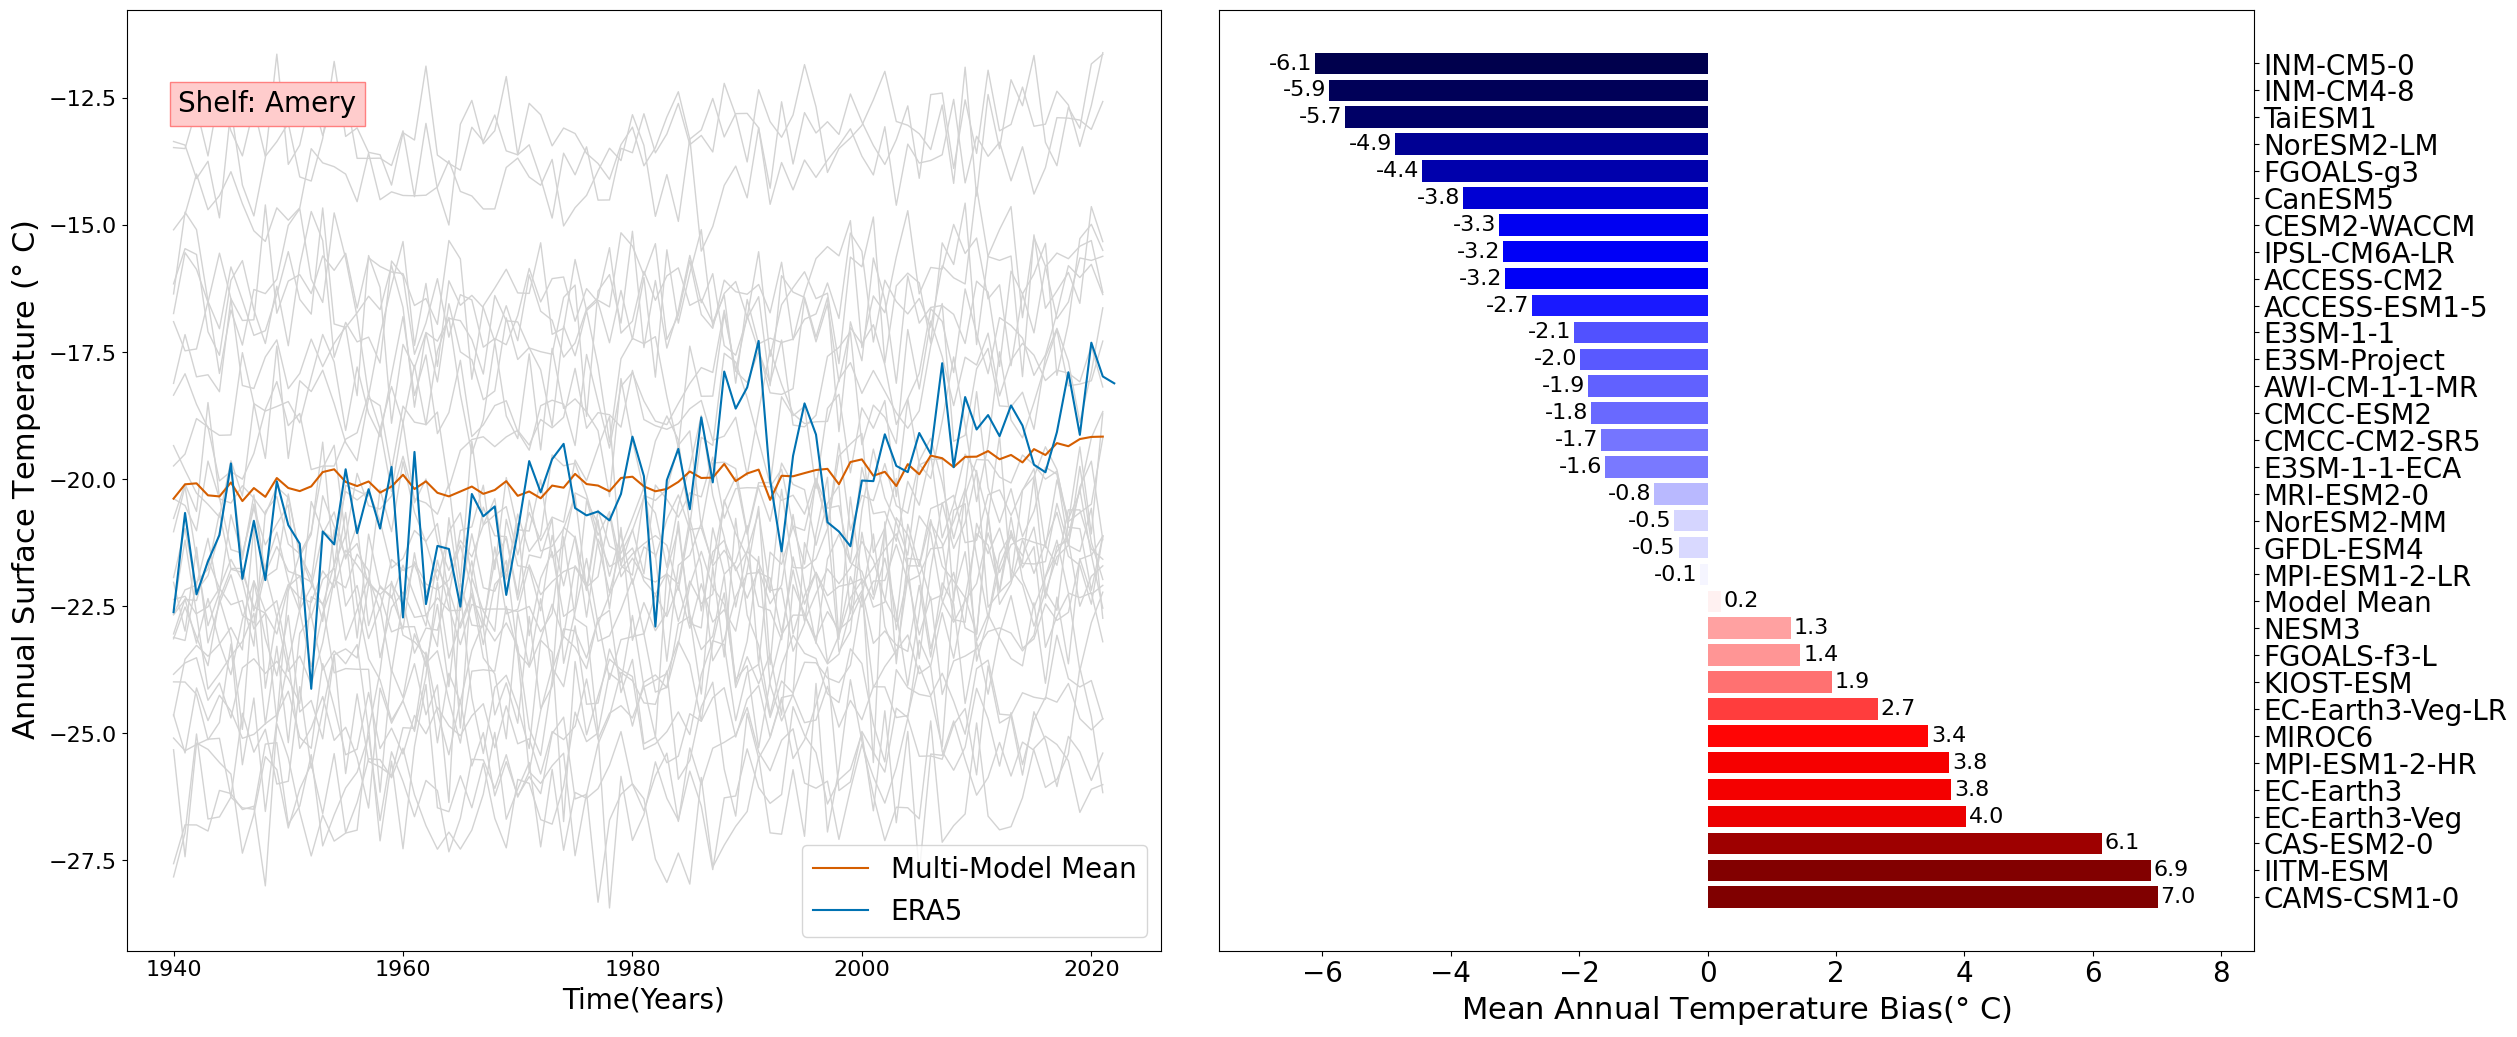

In [24]:
df, df_sorted, avg = bias_analysis_shelf('Amery','yearly')
print(avg)

In [47]:
def creating_model_bias_dict_and_plot(dictionary1,keys,shelf_name):   
    model_bias = list()
    names = list()
    
    shelf_sorted = dictionary1

    for i in range(len(dictionary1[shelf_name])):
        values = np.zeros(len(dictionary1))
        model_name = dictionary1[shelf_name]['Model Names'][i]
        names.append(model_name)

        k = 0
        for key in dictionary1:
            x = shelf_sorted[key]['Mean Bias'][i]
            values[k] = x
            k += 1
            
        weight = np.sum(values)
        model_bias.append(weight)

    df = pd.DataFrame(list(zip(names,model_bias)),columns=['Model Names','Weighted Mean Bias'])

    df_sortted = df.sort_values("Weighted Mean Bias",ascending=False)

    x = df_sortted['Model Names']
    y = df_sortted['Weighted Mean Bias']

    cmap = plt.cm.seismic
    norm = cm.colors.TwoSlopeNorm(vcenter=0,vmin=np.min(y),vmax=np.max(y))

    fig, (ax2) = plt.subplots(figsize=(15,12))
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    bars = ax2.barh(x,y,align='center',color=cmap(norm(y.values)))
    ax2.bar_label(bars,fmt = '%1.1f',padding=2,label_type='edge',fontsize=14)
    ax2.set_xlim(left=min(y)-1)
    ax2.set_xlabel(r"Mean Annual Temperature Bias($\degree$ C)", fontsize = 14)

    my_path = '/raid01/mafields/tas/MODELS_filtered/ssp585/figures/bias/' # Figures out the absolute path for you in case your working directory moves around.
    my_file = 'weighted_yearly_bias_All_Shelves.png'

    plt.savefig(os.path.join(my_path, my_file),bbox_inches='tight')
    
    return fig,df_sortted

In [14]:
def bias_analysis_shelf_alphabet(dictionary):
    
    new_dictionary = {}
    
    for key in dictionary:
        new_dictionary[key] = dictionary[key].sort_values('Model Names')
    
    return new_dictionary

In [15]:
dict_test = {}

In [16]:
dict_test['Amery'] = df
print(dict_test)

{'Amery':          Model Names  Mean Bias
0           E3SM-1-1  -2.073267
1         CAS-ESM2-0   6.139711
2          KIOST-ESM   1.936641
3       E3SM-Project  -1.985334
4        CAMS-CSM1-0   7.009019
5      MPI-ESM1-2-HR   3.765272
6          INM-CM4-8  -5.896535
7          INM-CM5-0  -6.108723
8        FGOALS-f3-L   1.445924
9      AWI-CM-1-1-MR  -1.866038
10           TaiESM1  -5.650776
11      CMCC-CM2-SR5  -1.658620
12         CMCC-ESM2  -1.812731
13      IPSL-CM6A-LR  -3.189026
14         EC-Earth3   3.793064
15          IITM-ESM   6.909706
16        NorESM2-MM  -0.524101
17         FGOALS-g3  -4.448660
18     ACCESS-ESM1-5  -2.732842
19        NorESM2-LM  -4.869173
20        ACCESS-CM2  -3.160612
21         GFDL-ESM4  -0.450314
22     EC-Earth3-Veg   4.022240
23  EC-Earth3-Veg-LR   2.656917
24             NESM3   1.303803
25        MRI-ESM2-0  -0.825884
26           CanESM5  -3.807514
27            MIROC6   3.440411
28       CESM2-WACCM  -3.250117
29      E3SM-1-1-ECA  -1.60038

(32, 82)
Abbot
(32, 82)
Amery
(32, 82)
Atka
(32, 82)
Baudouin
(32, 82)
Borchgrevink
(32, 82)
Conger Glenzer
(32, 82)
Cook
(32, 82)
Cosgrove
(32, 82)
Crosson
(32, 82)
Dotson
(32, 82)
Drygalski
(32, 82)
Ekstrom
(32, 82)
Filchner
(32, 82)
George VI
(32, 82)
Getz
(32, 82)
Holmes
(32, 82)
Jelbart
(32, 82)
Land
(32, 82)
LarsenB
(32, 82)
LarsenC
(32, 82)
LarsenD
(32, 82)
Lazarev
(32, 82)
Mariner
(32, 82)
Mertz
(32, 82)
Moscow University
(32, 82)
Nansen
(32, 82)
Nickerson
(32, 82)
Nivl
(32, 82)
pine island
(32, 82)
Prince Harald
(32, 82)
Quar
(32, 82)
Rennick
(32, 82)
Riiser-Larsen
(32, 82)
Ronne
(32, 82)
Ross East
(32, 82)
Ross West
(32, 82)
Shackleton
(32, 82)
Stange
(32, 82)
Sulzberger
(32, 82)
Thwaites
(32, 82)
Totten
(32, 82)
Venable
(32, 82)
Vigrid
(32, 82)
West
(32, 82)
Withrow


'completed task'

<Figure size 640x480 with 0 Axes>

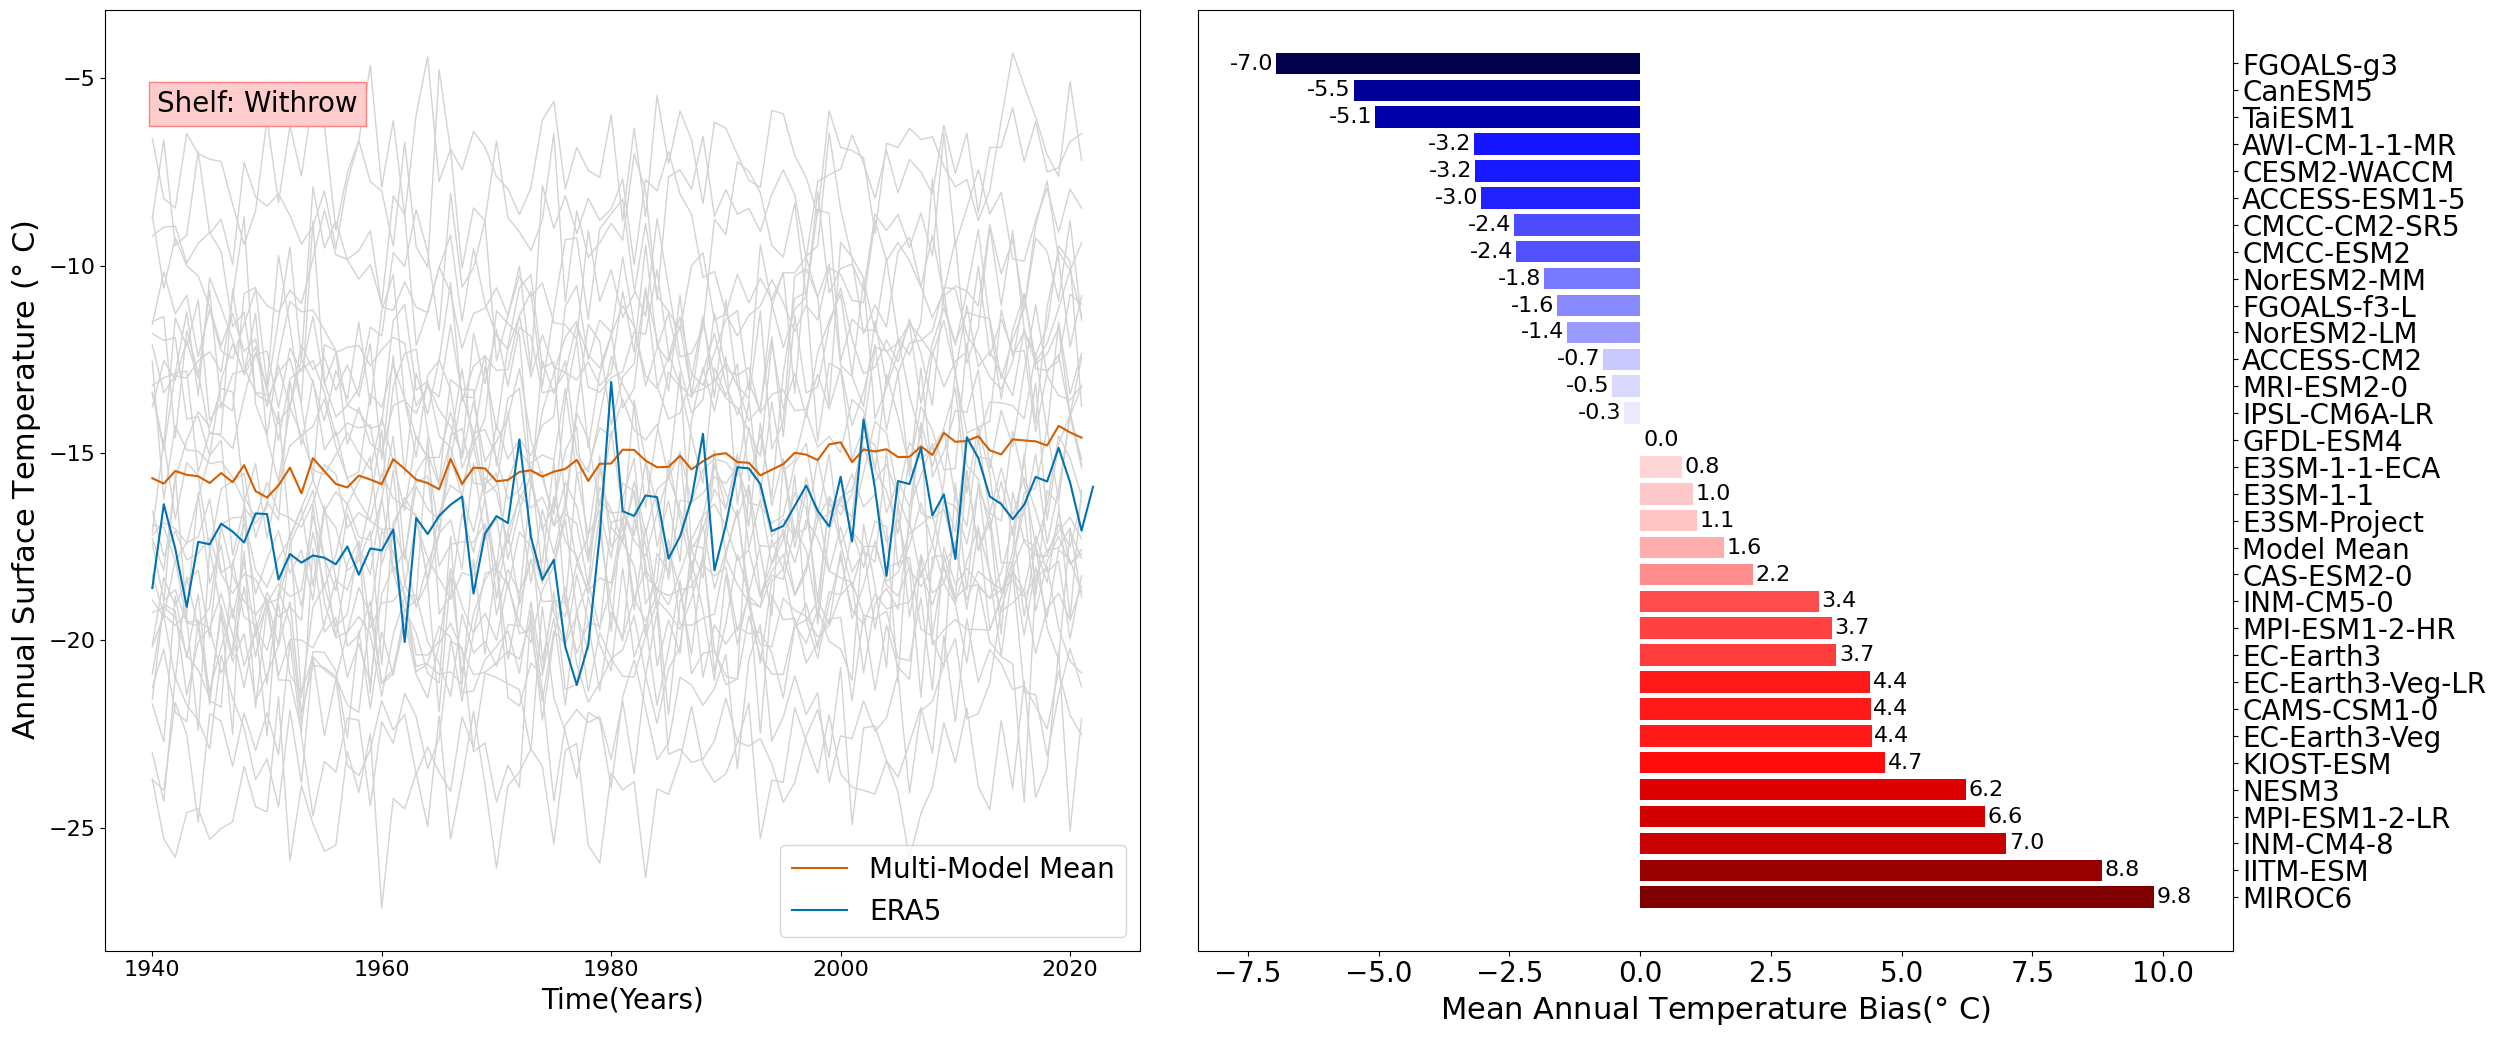

In [27]:
iceshelf_dictionary(yearly_shelves,'yearly')

In [28]:
std_of_models_yearly

{'Abbot': 3.880912452061732,
 'Amery': 5.153755139741879,
 'Atka': 4.18515251644469,
 'Baudouin': 4.462284051141713,
 'Borchgrevink': 4.625062429533205,
 'Conger Glenzer': 3.7677402127401796,
 'Cook': 4.1490530145997875,
 'Cosgrove': 4.295266475898871,
 'Crosson': 3.946104085359826,
 'Dotson': 3.8183638317912845,
 'Drygalski': 4.533707111117738,
 'Ekstrom': 4.062233233944991,
 'Filchner': 5.6965473438982,
 'George VI': 3.7736090946861176,
 'Getz': 3.779525303144081,
 'Holmes': 4.2759092889962504,
 'Jelbart': 4.197408103128109,
 'Land': 4.124919702792213,
 'LarsenB': 3.3035504346229345,
 'LarsenC': 3.5628609803091806,
 'LarsenD': 3.812242008752018,
 'Lazarev': 4.771029247348227,
 'Mariner': 4.620165271625307,
 'Mertz': 4.095787096213749,
 'Moscow University': 4.447953812283984,
 'Nansen': 5.207769682351386,
 'Nickerson': 4.440529983119727,
 'Nivl': 4.750180787293022,
 'pine island': 4.048072718429963,
 'Prince Harald': 4.376512322913437,
 'Quar': 3.9855577089304663,
 'Rennick': 4.238924

In [51]:
with open('std_of_models_yearly.pkl', 'wb') as f:
    pickle.dump(std_of_models_yearly, f)

(31, 83, 5, 57)
Abbot
(31, 83, 20, 30)
Amery
(31, 83, 2, 7)
Atka
(31, 83, 8, 37)
Baudouin
(31, 83, 5, 31)
Borchgrevink
(31, 83, 3, 4)
Conger Glenzer
(31, 83, 2, 11)
Cook
(31, 83, 2, 11)
Cosgrove
(31, 83, 3, 16)
Crosson
(31, 83, 4, 12)
Dotson
(31, 83, 2, 18)
Drygalski
(31, 83, 4, 9)
Ekstrom
(31, 83, 23, 127)
Filchner
(31, 83, 14, 33)
George VI
(31, 83, 5, 79)
Getz
(31, 83, 4, 8)
Holmes
(31, 83, 4, 13)
Jelbart
(31, 83, 2, 4)
Land
(31, 83, 2, 5)
LarsenB
(31, 83, 11, 23)
LarsenC
(31, 83, 19, 17)
LarsenD
(31, 83, 4, 13)
Lazarev
(31, 83, 2, 10)
Mariner
(31, 83, 5, 11)
Mertz
(31, 83, 3, 20)
Moscow University
(31, 83, 3, 6)
Nansen
(31, 83, 4, 23)
Nickerson
(31, 83, 3, 15)
Nivl
(31, 83, 4, 13)
pine island
(31, 83, 4, 18)
Prince Harald
(31, 83, 3, 6)
Quar
(31, 83, 5, 7)
Rennick
(31, 83, 11, 39)
Riiser-Larsen
(31, 83, 36, 145)
Ronne
(31, 83, 61, 209)
Ross East
(31, 83, 61, 209)
Ross West
(31, 83, 8, 24)
Shackleton
(31, 83, 5, 18)
Stange
(31, 83, 6, 28)
Sulzberger
(31, 83, 3, 20)
Thwaites
(31, 83,

'completed task'

<Figure size 640x480 with 0 Axes>

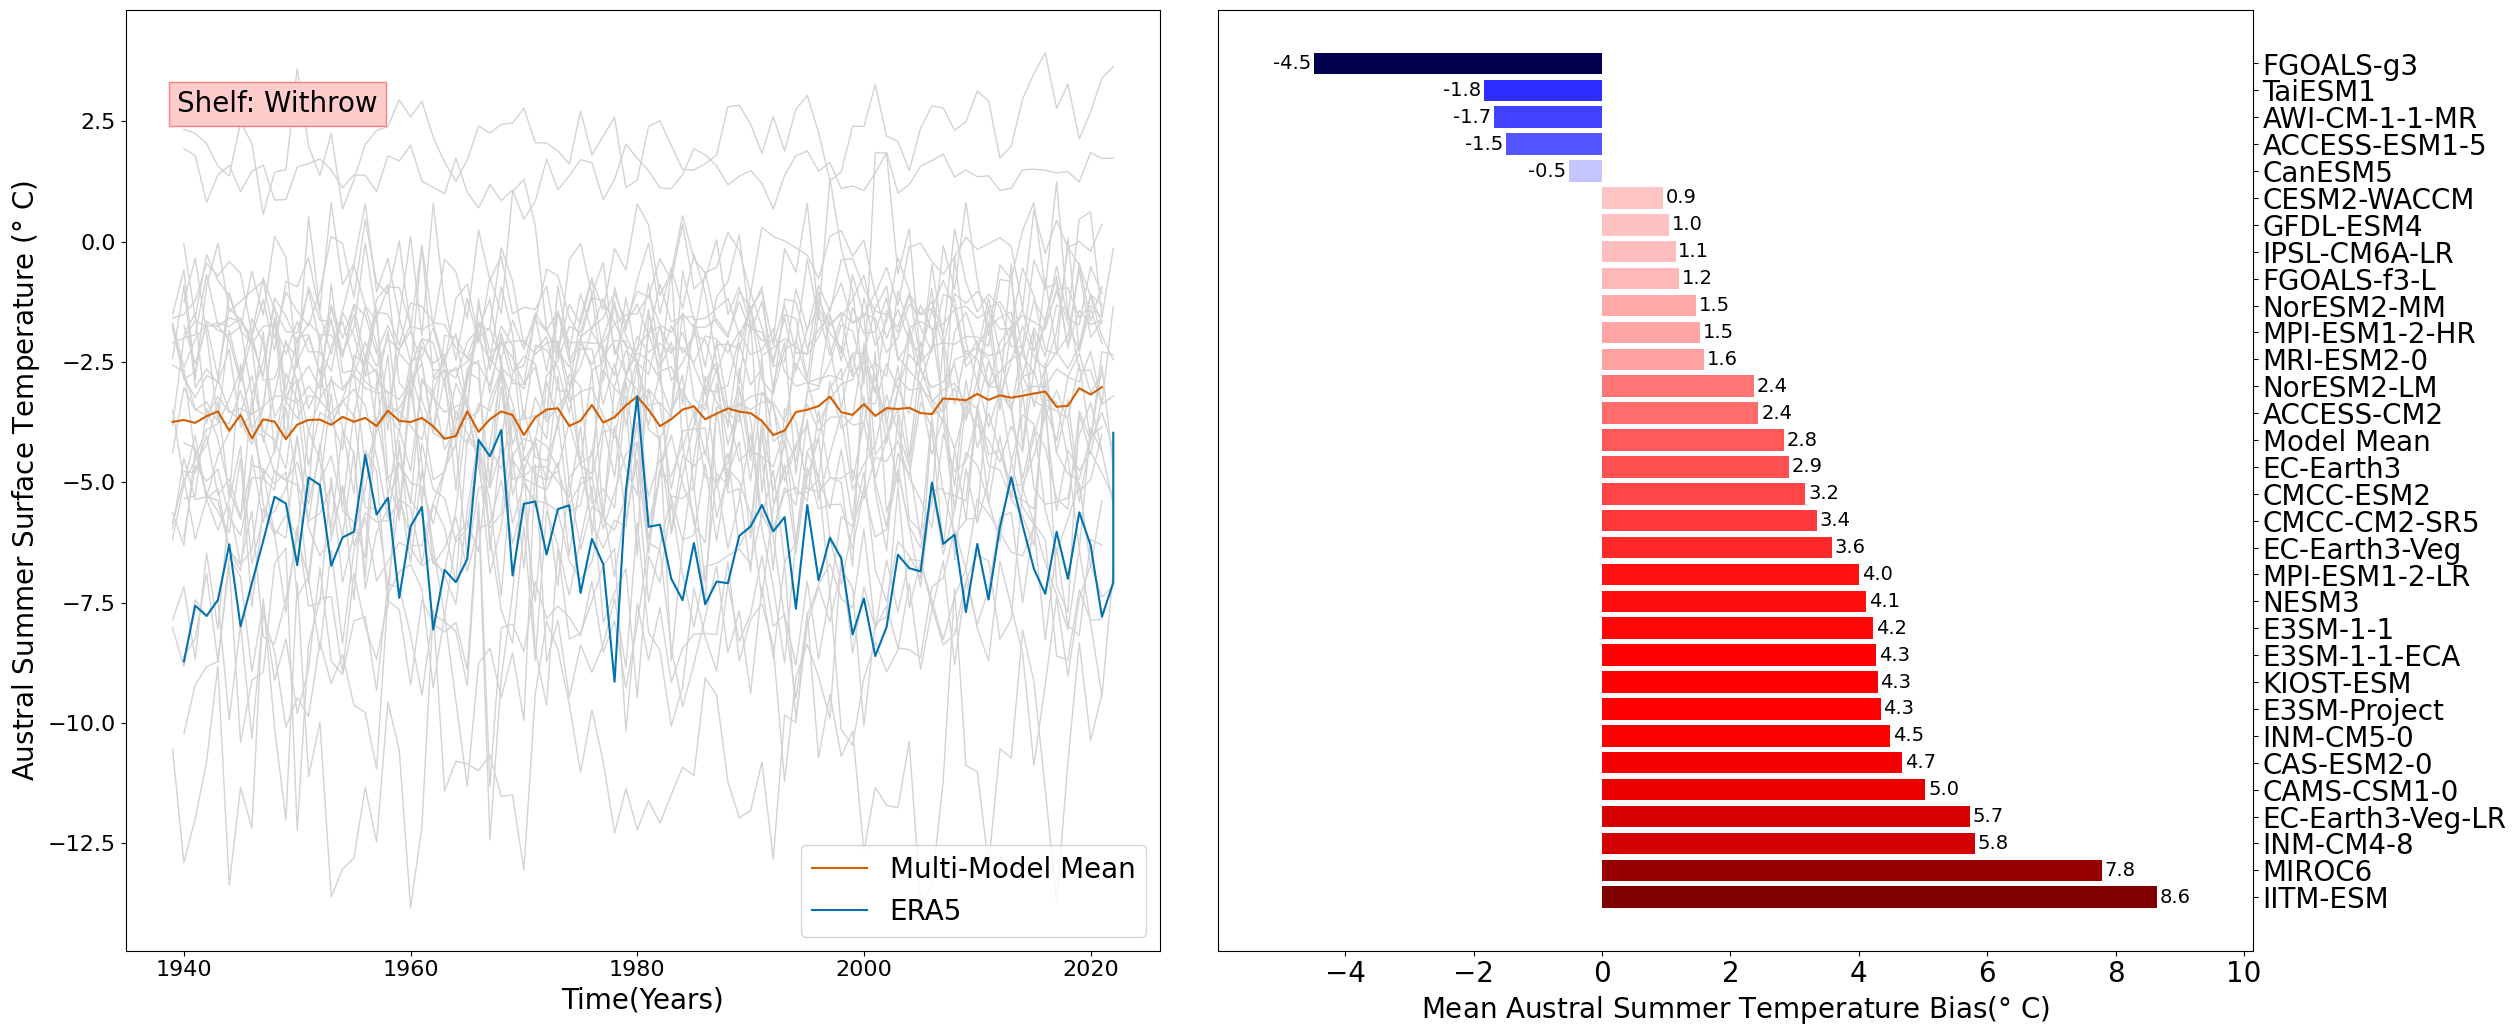

In [29]:
iceshelf_dictionary(seasonal_shelves,'seasonal')

In [50]:
std_of_models_seasonal
with open('std_of_models_seasonal.pkl', 'wb') as f:
    pickle.dump(std_of_models_seasonal, f)

In [33]:
bias_analysis_shelf_alphabet_yearly = bias_analysis_shelf_alphabet(bias_analysis_yearly)
bias_analysis_shelf_alphabet_yearly

all_shelves_model_mean_yearly_value = {}

for key in bias_analysis_shelf_alphabet_yearly: 
    print(bias_analysis_shelf_alphabet_yearly[key]['Model Names'][31], bias_analysis_shelf_alphabet_yearly[key]['Mean Bias'][31])
    all_shelves_model_mean_yearly_value[key] = bias_analysis_shelf_alphabet_yearly[key]['Mean Bias'][31]

Model Mean 0.4327213378756694
Model Mean 0.20454428110556244
Model Mean 2.9376454295075853
Model Mean 1.1341053253265627
Model Mean 1.1251071003568407
Model Mean 0.294862434372695
Model Mean -0.24163125974413363
Model Mean 0.42386203109862297
Model Mean 0.6863657376007226
Model Mean 1.204384353910082
Model Mean 0.35411762574386263
Model Mean 3.5192334967484076
Model Mean 2.111019989653805
Model Mean -3.2677502159356373
Model Mean 0.775293765075911
Model Mean -1.320893565157235
Model Mean 2.4472345133953533
Model Mean 2.0004025819282
Model Mean 3.241598157904642
Model Mean 2.4191237609490677
Model Mean 1.2761211350185828
Model Mean 1.743604878662267
Model Mean -1.825975784822631
Model Mean 0.5209905968983823
Model Mean -0.6501363875180116
Model Mean -1.860309192988105
Model Mean 2.187870124993316
Model Mean 0.8899199319100766
Model Mean -1.0149046648349824
Model Mean -1.8811516156649242
Model Mean 2.902727561956203
Model Mean -0.19195125252466555
Model Mean 4.3200472573181345
Model Mean

In [34]:
all_shelves_model_mean_yearly_value

{'Abbot': 0.4327213378756694,
 'Amery': 0.20454428110556244,
 'Atka': 2.9376454295075853,
 'Baudouin': 1.1341053253265627,
 'Borchgrevink': 1.1251071003568407,
 'Conger Glenzer': 0.294862434372695,
 'Cook': -0.24163125974413363,
 'Cosgrove': 0.42386203109862297,
 'Crosson': 0.6863657376007226,
 'Dotson': 1.204384353910082,
 'Drygalski': 0.35411762574386263,
 'Ekstrom': 3.5192334967484076,
 'Filchner': 2.111019989653805,
 'George VI': -3.2677502159356373,
 'Getz': 0.775293765075911,
 'Holmes': -1.320893565157235,
 'Jelbart': 2.4472345133953533,
 'Land': 2.0004025819282,
 'LarsenB': 3.241598157904642,
 'LarsenC': 2.4191237609490677,
 'LarsenD': 1.2761211350185828,
 'Lazarev': 1.743604878662267,
 'Mariner': -1.825975784822631,
 'Mertz': 0.5209905968983823,
 'Moscow University': -0.6501363875180116,
 'Nansen': -1.860309192988105,
 'Nickerson': 2.187870124993316,
 'Nivl': 0.8899199319100766,
 'pine island': -1.0149046648349824,
 'Prince Harald': -1.8811516156649242,
 'Quar': 2.9027275619562

In [35]:
with open('all_shelves_model_mean_yearly_value.pkl', 'wb') as f:
    pickle.dump(all_shelves_model_mean_yearly_value, f)

In [37]:
bias_analysis_shelf_alphabet_seasonal = bias_analysis_shelf_alphabet(bias_analysis_seasonal)
bias_analysis_shelf_alphabet_seasonal

all_shelves_model_mean_seasonal_value = {}

for key in bias_analysis_shelf_alphabet_seasonal: 
    print(bias_analysis_shelf_alphabet_seasonal[key]['Model Names'][31], bias_analysis_shelf_alphabet_seasonal[key]['Mean Bias'][31])
    all_shelves_model_mean_seasonal_value[key] = bias_analysis_shelf_alphabet_seasonal[key]['Mean Bias'][31]


Model Mean 1.934894972749733
Model Mean 1.949438431450848
Model Mean 2.6160779488435852
Model Mean 2.0891636406855283
Model Mean 2.2127668178387747
Model Mean 0.9963723117719961
Model Mean -0.010468996761629382
Model Mean 2.0168670865281175
Model Mean 2.415915978230407
Model Mean 2.872943097665481
Model Mean 0.8955925499961488
Model Mean 3.231817462916572
Model Mean 3.9232049415753067
Model Mean -1.638556133603341
Model Mean 1.7900625924304645
Model Mean -0.18909647500424287
Model Mean 2.369080818427171
Model Mean 2.2259602227312487
Model Mean 1.0402513952116605
Model Mean 0.5208524740834338
Model Mean -0.14485623449001558
Model Mean 2.098437416494178
Model Mean -1.6759139989950218
Model Mean 1.123839141256677
Model Mean 0.3071985535912034
Model Mean -0.09683394114996505
Model Mean 2.443812162468604
Model Mean 1.1283530894164207
Model Mean 0.9781474535190108
Model Mean -0.25301073188490936
Model Mean 2.8842425294884646
Model Mean 0.23958298363806538
Model Mean 3.9867001060786507
Model 

In [38]:
all_shelves_model_mean_seasonal_value

{'Abbot': 1.934894972749733,
 'Amery': 1.949438431450848,
 'Atka': 2.6160779488435852,
 'Baudouin': 2.0891636406855283,
 'Borchgrevink': 2.2127668178387747,
 'Conger Glenzer': 0.9963723117719961,
 'Cook': -0.010468996761629382,
 'Cosgrove': 2.0168670865281175,
 'Crosson': 2.415915978230407,
 'Dotson': 2.872943097665481,
 'Drygalski': 0.8955925499961488,
 'Ekstrom': 3.231817462916572,
 'Filchner': 3.9232049415753067,
 'George VI': -1.638556133603341,
 'Getz': 1.7900625924304645,
 'Holmes': -0.18909647500424287,
 'Jelbart': 2.369080818427171,
 'Land': 2.2259602227312487,
 'LarsenB': 1.0402513952116605,
 'LarsenC': 0.5208524740834338,
 'LarsenD': -0.14485623449001558,
 'Lazarev': 2.098437416494178,
 'Mariner': -1.6759139989950218,
 'Mertz': 1.123839141256677,
 'Moscow University': 0.3071985535912034,
 'Nansen': -0.09683394114996505,
 'Nickerson': 2.443812162468604,
 'Nivl': 1.1283530894164207,
 'pine island': 0.9781474535190108,
 'Prince Harald': -0.25301073188490936,
 'Quar': 2.884242529

In [39]:
with open('all_shelves_model_mean_seasonal_value.pkl', 'wb') as f:
    pickle.dump(all_shelves_model_mean_seasonal_value, f)

### Weights for Shelves

In [40]:
#Weights for Analysis of the Ross Iceshelf

keys = list(('Ross East','Ross West'))

weights_Ross = shelf_weights(yearly_shelves,'yearly',keys)

print(weights_Ross)

{'Ross East': 0.37747554282987356, 'Ross West': 0.6225244571701265}


In [41]:
#Weights for Analysis of the Ronne-Filchner

keys = list(('Ronne','Filchner'))

weights_Ronne_Filchner = shelf_weights(yearly_shelves,'yearly',keys)

print(weights_Ronne_Filchner)

{'Ronne': 0.7420069642291864, 'Filchner': 0.25799303577081356}


In [42]:
#Weights for Analysis of the Larsen Iceshelf

keys = list(('LarsenB','LarsenC','LarsenD'))

weights_Larsen = shelf_weights(yearly_shelves,'yearly',keys)

print(weights_Larsen)


{'LarsenB': 0.023076923076923078, 'LarsenC': 0.6038461538461538, 'LarsenD': 0.3730769230769231}


In [43]:
##Weights for All Shelves

gridsize_shelves = iceshelf_gridsize(yearly_shelves,'yearly')

total_shelf_weights = {}

for key in gridsize_shelves: 
    total_shelf_weights[key] = gridsize_shelves[key]/sum(gridsize_shelves.values())

print(total_shelf_weights)

{'Abbot': 0.015256588072122053, 'Amery': 0.025285394217433053, 'Atka': 0.0009602048436999893, 'Baudouin': 0.013229488957644298, 'Borchgrevink': 0.008961911874533234, 'Conger Glenzer': 0.0004267577083111064, 'Cook': 0.001280273124933319, 'Cosgrove': 0.0011735836978555424, 'Crosson': 0.0016003414061666488, 'Dotson': 0.0032006828123332977, 'Drygalski': 0.0008535154166222128, 'Ekstrom': 0.002560546249866638, 'Filchner': 0.08695188306838793, 'George VI': 0.01066894270777766, 'Getz': 0.01749706604075536, 'Holmes': 0.0008535154166222128, 'Jelbart': 0.004480955937266617, 'Land': 0.00032006828123332977, 'LarsenB': 0.0006401365624666595, 'LarsenC': 0.016750240051210924, 'LarsenD': 0.010348874426544329, 'Lazarev': 0.0037341299477221808, 'Mariner': 0.0014936519790888724, 'Mertz': 0.002027099114477755, 'Moscow University': 0.0016003414061666488, 'Nansen': 0.0009602048436999893, 'Nickerson': 0.004160887656033287, 'Nivl': 0.002880614531099968, 'pine island': 0.0036274405206444043, 'Prince Harald': 0.

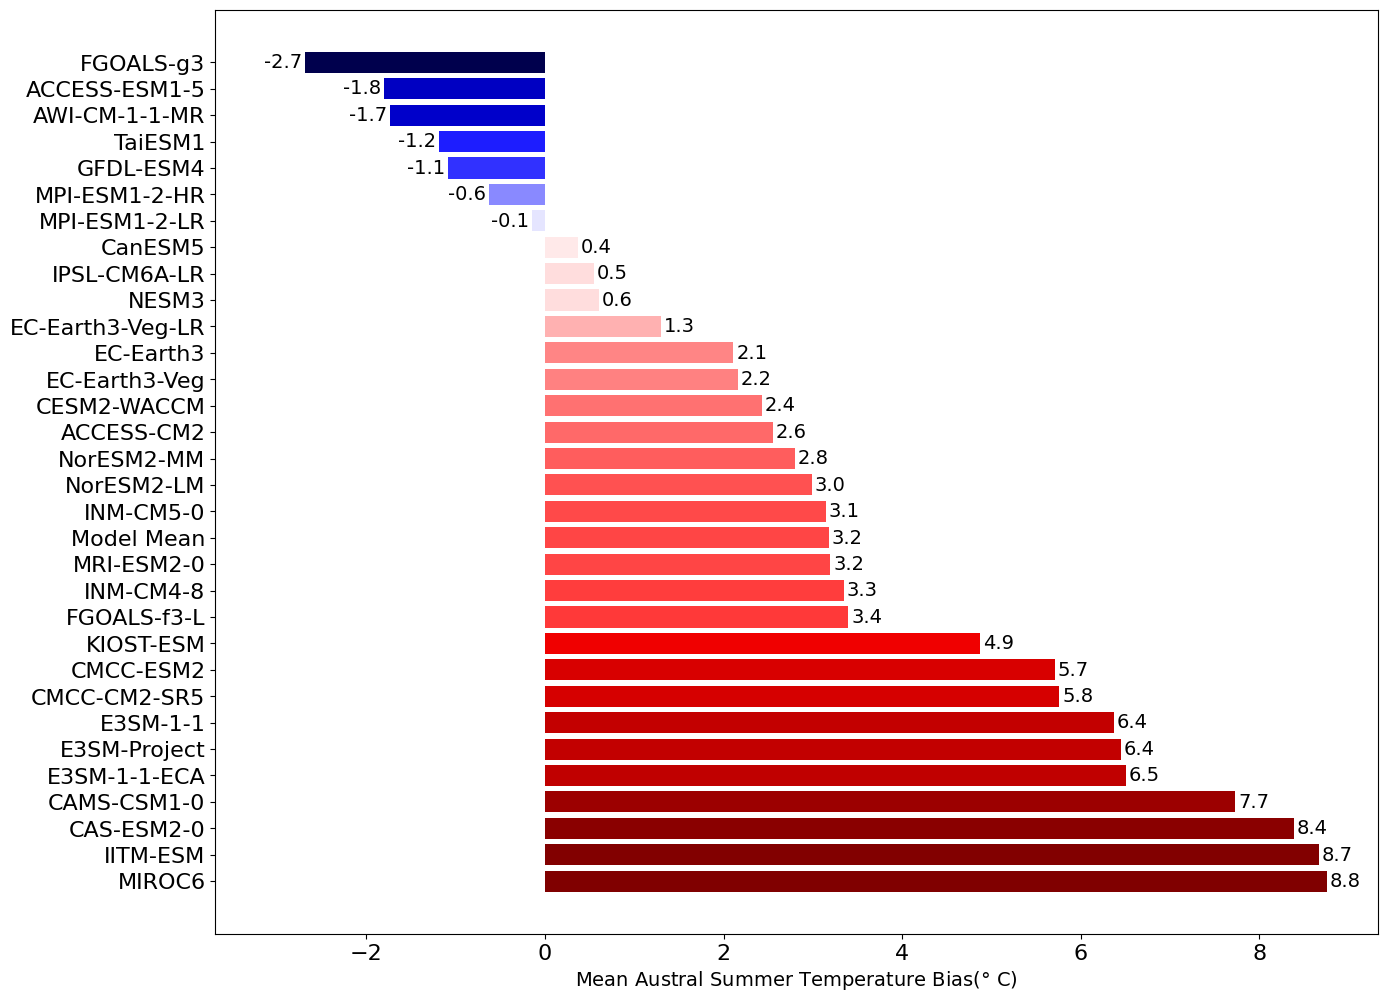

In [46]:
keys = bias_analysis_shelf_alphabet_seasonal.keys()

applied_weights_all_shelves_seasonal = grouping_bias_analysis(bias_analysis_shelf_alphabet_seasonal,total_shelf_weights,keys)

all_shelves_seasonal_fig, weights_all_shelves_seasonal_sortted = creating_model_bias_dict_and_plot(applied_weights_all_shelves_seasonal,keys,'Ross East')

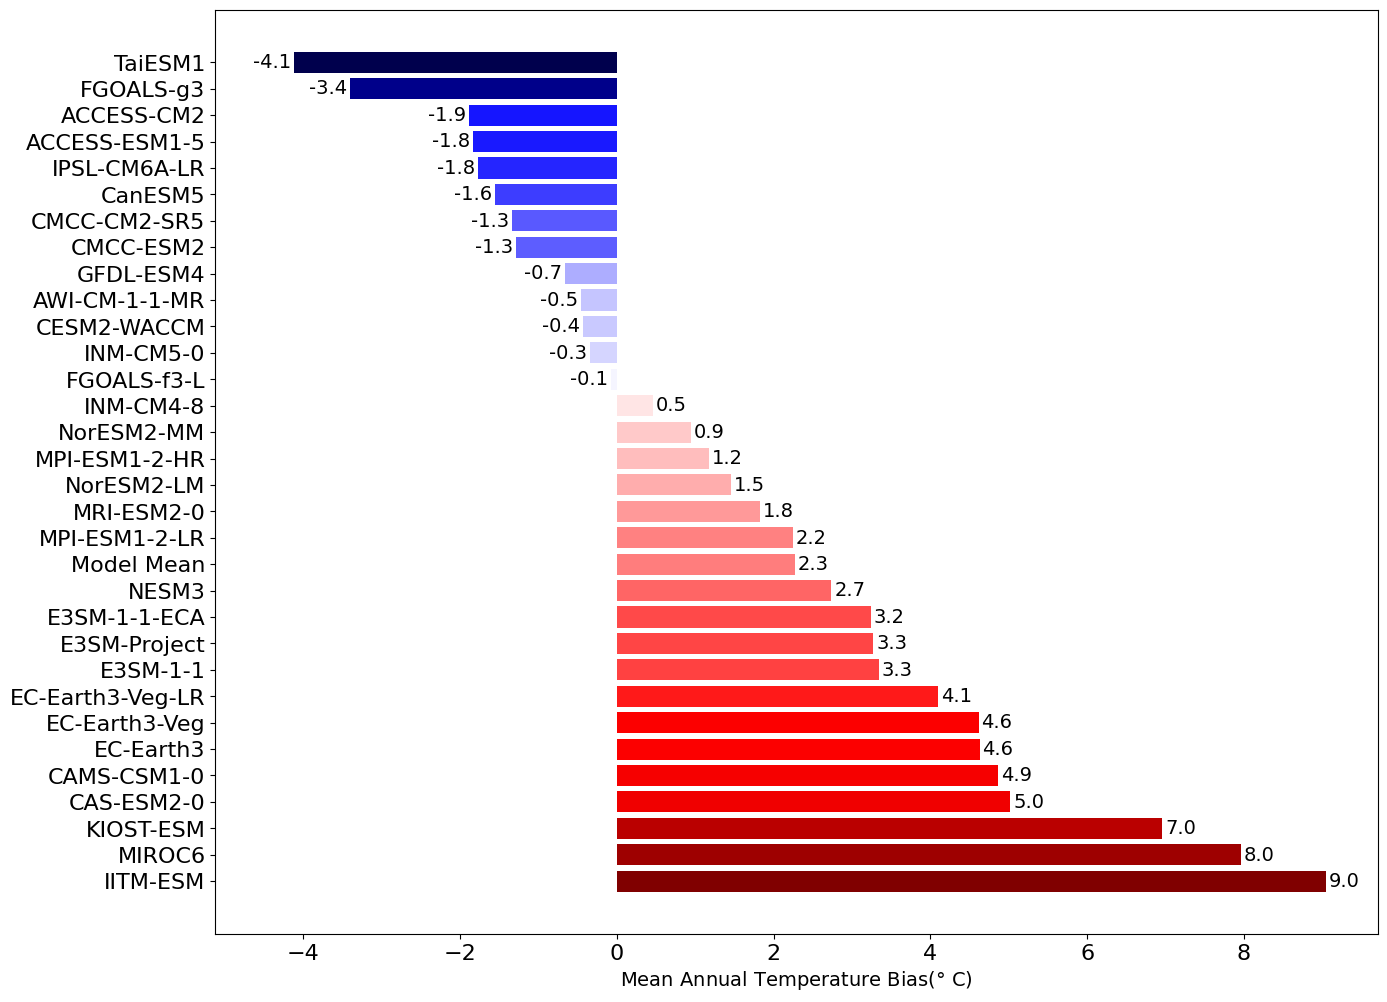

In [48]:
keys = bias_analysis_shelf_alphabet_yearly.keys()

applied_weights_all_shelves_yearly = grouping_bias_analysis(bias_analysis_shelf_alphabet_yearly,total_shelf_weights,keys)

all_shelves_yearly_fig, weights_all_shelves_yearly_sortted = creating_model_bias_dict_and_plot(applied_weights_all_shelves_yearly,keys,'Ross East')

In [29]:
yearly_bias_all_shelves_alpabet = weights_all_shelves_yearly_sortted.sort_values('Model Names')

In [30]:
yearly_bias_all_shelves_alpabet

,Model Names,Weighted Mean Bias
20,ACCESS-CM2,-1.892284
18,ACCESS-ESM1-5,-1.842020
9,AWI-CM-1-1-MR,-0.462881
4,CAMS-CSM1-0,4.864651
1,CAS-ESM2-0,5.018729
28,CESM2-WACCM,-0.431917
11,CMCC-CM2-SR5,-1.341395
12,CMCC-ESM2,-1.290084
26,CanESM5,-1.556835
0,E3SM-1-1,3.341211


In [31]:
with open('yearly_bias_all_shelves_alpabet.pkl', 'wb') as f:
    pickle.dump(yearly_bias_all_shelves_alpabet, f)

In [32]:
seasonal_bias_all_shelves_alpabet = weights_all_shelves_seasonal_sortted.sort_values('Model Names')

In [33]:
seasonal_bias_all_shelves_alpabet

,Model Names,Weighted Mean Bias
20,ACCESS-CM2,2.550482
18,ACCESS-ESM1-5,-1.798328
9,AWI-CM-1-1-MR,-1.738627
4,CAMS-CSM1-0,7.728768
1,CAS-ESM2-0,8.382861
28,CESM2-WACCM,2.433214
11,CMCC-CM2-SR5,5.760919
12,CMCC-ESM2,5.708358
26,CanESM5,0.374181
0,E3SM-1-1,6.367486


In [34]:
with open('seasonal_bias_all_shelves_alpabet.pkl', 'wb') as f:
    pickle.dump(seasonal_bias_all_shelves_alpabet, f)

In [48]:
fname = '/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/TT_IS.nc'
datain = Dataset(fname, 'r')

fname_1 = '/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/dT_IS.nc'
datain1 = Dataset(fname_1, 'r')

TT = datain.variables['thresholdT'][:]
TT_uncertainty = datain1.variables['dTT'][:]


Names = ['Nansen','Drygalski','Ross West','Filchner','Ross East','Vigrid','Ronne','Amery',
        'Publications','Baudouin','Tracy Tremenchus','Lazarev','Rennick','LarsenB','Quar','Riiser-Larsen'
        'Brunt Stancomb','Tucker','Lily','Borchgrevink','Ekstrom','Mariner','Fimbul','Nivl','LarsenD'
        'Bach','LarsenC','LarsenE','Cook','West','Cosgrove','Jelbart','Sulzberger','Conger Glenzer',
        'Ninnis','Mertz','Pine Island','Shackleton','George VI','Moscow University','Nickerson','Prince Harald'
        ,'Wilkins','Thwaites','Frostman-Lord-Shuman-Anandakri','Stange','Getz','Slava','Dotson','Swinburne',
        'Crosson','Abbot','Totten','Land','Venable','Holmes']

Thresholds = pd.DataFrame(list(zip(Names,TT,TT_uncertainty)),columns=['Shelf Names','Threshold Temps','Temp Uncertainty'])

In [49]:
Thresholds 

,Shelf Names,Threshold Temps,Temp Uncertainty
0,Nansen,-20.118471,2.011847
1,Drygalski,-20.925136,0.755822
2,Ross West,-20.570977,1.204529
3,Filchner,-17.713133,0.889902
4,Ross East,-18.728981,1.186594
5,Vigrid,-14.731370,0.760710
6,Ronne,-15.878980,0.657938
7,Amery,-20.228553,1.168172
8,Publications,-15.670661,1.567066
9,Baudouin,-12.936224,0.495351
